
###**Data Preparation**

In [10]:
pip install wandb

In [14]:
!wandb login 88438112c1e3c693fd7cac1adf4ccfded7b8274a

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import os
import cv2
from patchify import patchify
from PIL import Image
import numpy as np
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from matplotlib import pyplot as plt

In [ ]:
!ls -lah '/content/drive/MyDrive/CV_Segment'
os.chdir('/content/drive/MyDrive/CV_Segment')

total 33K
-rw------- 1 root root  548 May 29  2020  classes.json
drwx------ 4 root root 4.0K Jun 25 12:25 'Tile 1'
drwx------ 4 root root 4.0K Jun 25 12:25 'Tile 2'
drwx------ 4 root root 4.0K Jun 25 12:25 'Tile 3'
drwx------ 4 root root 4.0K Jun 25 12:25 'Tile 4'
drwx------ 4 root root 4.0K Jun 25 12:25 'Tile 5'
drwx------ 4 root root 4.0K Jun 25 12:25 'Tile 6'
drwx------ 4 root root 4.0K Jun 25 12:25 'Tile 7'
drwx------ 4 root root 4.0K Jun 25 12:25 'Tile 8'


In [ ]:
dataset_root_folder = '/content/drive/MyDrive/CV_Segment'

In [ ]:
image_patch_size = 256
minmaxscaler = MinMaxScaler()

In [ ]:
image_dataset = []
image_extension = 'jpg' #png
image_type = 'images' #masks
for tile_id in range(1,8):
  for image_id in range(1,10):
    image = cv2.imread(f'Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
    if image is not None:
      size_x = (image.shape[1]//image_patch_size)*image_patch_size
      size_y = (image.shape[0]//image_patch_size)*image_patch_size
      image = Image.fromarray(image)
      image = image.crop((0,0,size_x,size_y))
      image = np.array(image)
      patched_images = patchify(image,(image_patch_size,image_patch_size,3),step = image_patch_size)
      for i in range(patched_images.shape[0]):
        for j in range(patched_images.shape[1]):
          individual_patched_image = patched_images[i,j,:,:]
          individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1,individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
          individual_patched_image = individual_patched_image[0]
          image_dataset.append(individual_patched_image)


In [ ]:
len(image_dataset)

945

In [ ]:
mask_dataset = []
image_extension = 'png' #png
image_type = 'masks' #masks
for tile_id in range(1,8):
  for image_id in range(1,10):
    image = cv2.imread(f'Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
    if image is not None:
      image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
      size_x = (image.shape[1]//image_patch_size)*image_patch_size
      size_y = (image.shape[0]//image_patch_size)*image_patch_size
      image = Image.fromarray(image)
      image = image.crop((0,0,size_x,size_y))
      image = np.array(image)
      patched_images = patchify(image,(image_patch_size,image_patch_size,3),step = image_patch_size)
      for i in range(patched_images.shape[0]):
        for j in range(patched_images.shape[1]):
          individual_patched_image = patched_images[i,j,:,:]
          individual_patched_image = individual_patched_image[0]
          mask_dataset.append(individual_patched_image)


In [ ]:
len(mask_dataset)
mask_dataset = np.array(mask_dataset)

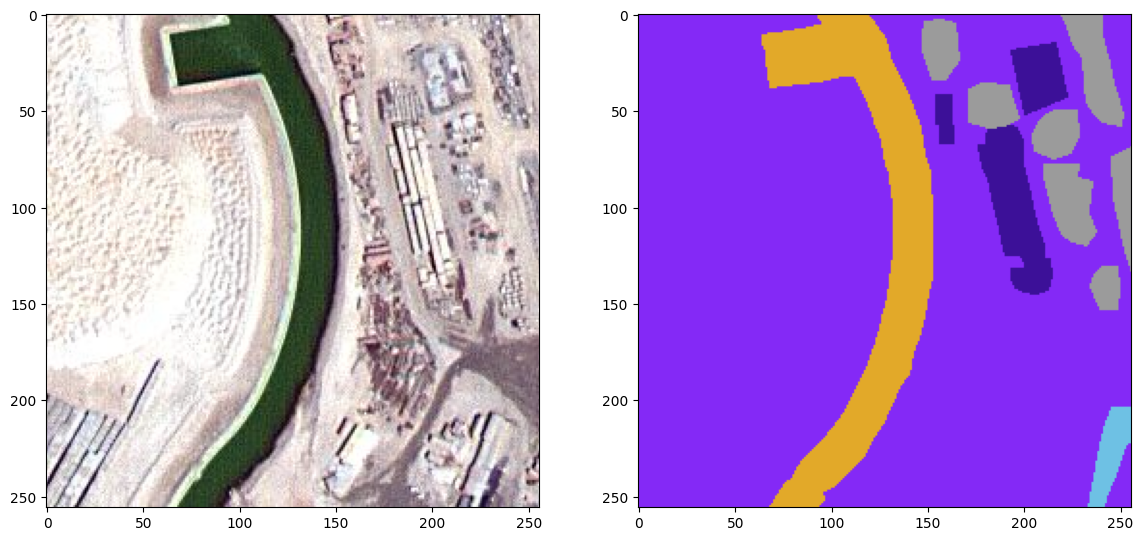

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[0])
plt.subplot(122)
plt.imshow(mask_dataset[0])

In [ ]:
class_building =  '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2],16) for i in (0,2,4)))

class_land =  '#8429F6'
class_land = class_land.lstrip('#')
class_land= np.array(tuple(int(class_land[i:i+2],16) for i in (0,2,4)))

class_road =  '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2],16) for i in (0,2,4)))

class_vegetation =  '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2],16) for i in (0,2,4)))

class_water =  '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2],16) for i in (0,2,4)))

class_unlabled =  '#9B9B9B'
class_unlabled = class_unlabled.lstrip('#')
class_unlabled = np.array(tuple(int(class_unlabled[i:i+2],16) for i in (0,2,4)))



In [ ]:
def rgb_to_label (label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment [np.all(label == class_water, axis=-1)] = 0
  label_segment [np.all(label == class_land, axis=-1)] = 1
  label_segment [np.all(label == class_road, axis=-1)] = 2
  label_segment [np.all(label == class_building, axis=-1)] = 3
  label_segment [np.all(label == class_vegetation, axis=-1)] = 4
  label_segment [np.all(label == class_unlabled, axis=-1)] = 5
  label_segment = label_segment[:,:,0]
  return label_segment

In [ ]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [ ]:
labels = np.array(labels)

In [ ]:
labels = np.expand_dims(labels,axis = 3)

In [ ]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

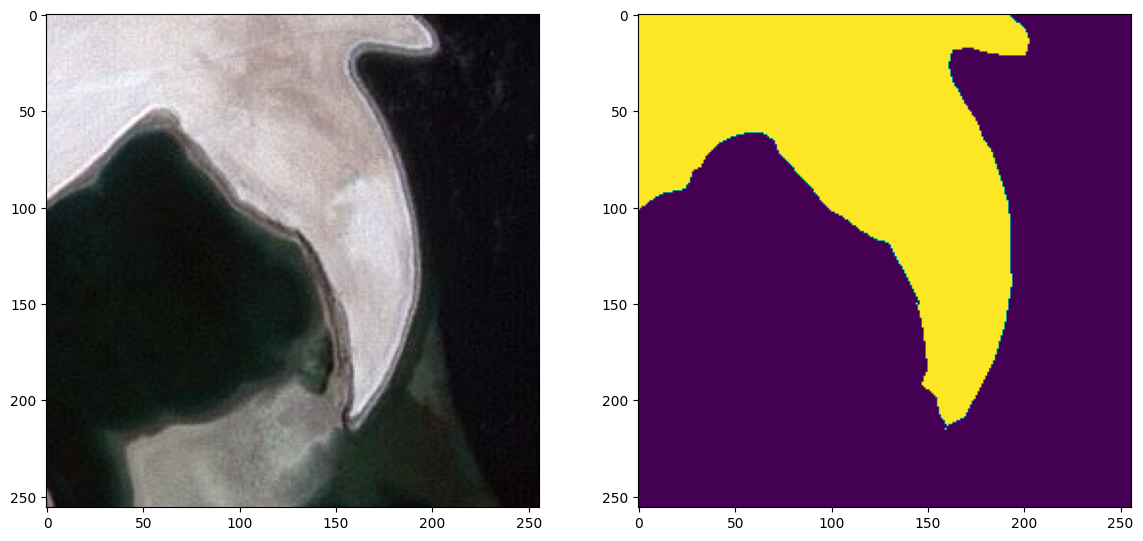

In [ ]:
random_image_id = np.random.randint(0,len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(labels[random_image_id][:,:,0])

In [ ]:
labels[0][:,:,0]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [ ]:
total_classes = len(np.unique(labels))

In [ ]:
total_classes

6

In [ ]:
master_training_dataset = image_dataset

In [ ]:
from keras.utils.np_utils import to_categorical

In [ ]:
labels_categorical_dataset = to_categorical(labels, num_classes = total_classes )

In [ ]:
labels_categorical_dataset.shape

(945, 256, 256, 6)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(master_training_dataset,labels_categorical_dataset,test_size = 0.15,random_state=100)

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
print(X_train.shape)

(803, 256, 256, 3)


In [ ]:
image_height = X_train.shape[2]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [ ]:
print(total_classes)

6


###**Deep Learning Model Preparation**

In [ ]:
!pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [ ]:
from keras import backend as K

In [ ]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [ ]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [ ]:
metrics = ["accuracy", jaccard_coef]

In [ ]:

print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [ ]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)


In [ ]:
model = get_deep_learning_model()

In [ ]:
model.get_config()

{'name': 'model',
 'trainable': True,
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   

### **Generating Loss Function**

In [ ]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]


In [ ]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0rc3, 2.6.0, 2.7.0rc0, 2.7.0rc2, 2.7.0, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.9.0rc0, 2.9.

In [ ]:
import segmentation_models as sm

In [ ]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [ ]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [ ]:
total_loss = dice_loss + (1 * focal_loss)

### **Model Compilation**

In [ ]:
import tensorflow as tf

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [15]:
import wandb
from wandb.keras import WandbCallback

In [ ]:
wandb.init(project="cs5133_new", entity="ajju")

wandb: ERROR Control-C detected -- Run data was not synced


Problem at: <ipython-input-19-f7e6ea266c7c> 1 <cell line: 1>


KeyboardInterrupt: ignored

In [18]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Just for my testing I am doing epochs 2 only
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=2,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/2
51/51 [==============================] - 748s 15s/step - loss: 0.9941 - accuracy: 0.5988 - jaccard_coef: 0.2959 - val_loss: 0.9829 - val_accuracy: 0.7039 - val_jaccard_coef: 0.3863
Epoch 2/2
51/51 [==============================] - 728s 14s/step - loss: 0.9701 - accuracy: 0.7021 - jaccard_coef: 0.4232 - val_loss: 0.9610 - val_accuracy: 0.7325 - val_jaccard_coef: 0.5080


In [ ]:
history_a = model_history

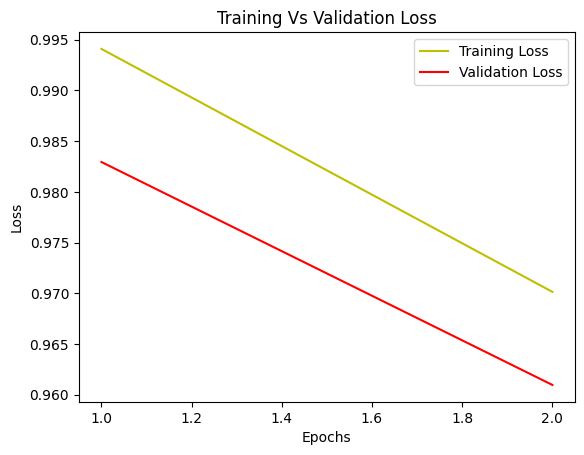

In [ ]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model_history.params

{'verbose': 1, 'epochs': 2, 'steps': 51}

In [ ]:
y_pred = model.predict(X_test)

5/5 [==============================] - 35s 6s/step


In [ ]:
len(y_pred)

142

In [ ]:
y_pred_argmax = np.argmax(y_pred, axis=3)

y_test_argmax = np.argmax(y_test, axis=3)

### **Comparing Prediction Results**

In [ ]:
import random

test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]


1/1 [==============================] - 0s 196ms/step


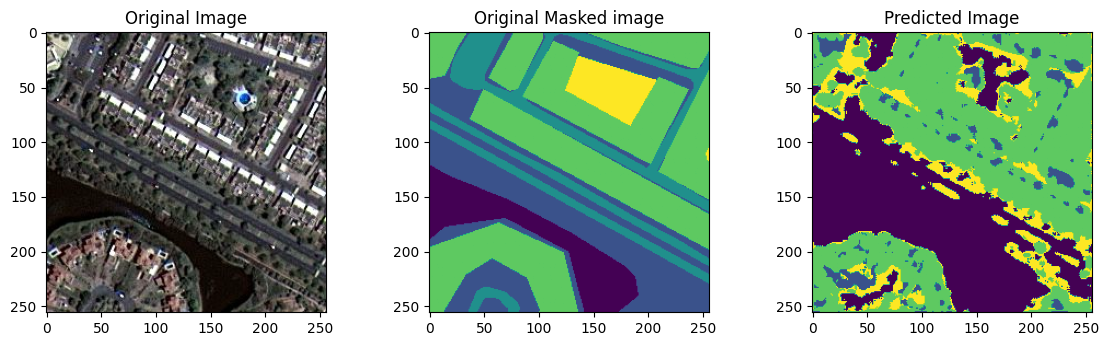

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [ ]:
model.save("satellite_segmentation_full.h5")

In [ ]:
!ls -lah

total 23M
-rw------- 1 root root  548 May 29  2020  classes.json
-rw------- 1 root root  23M Jun 27 19:32  satellite_segmentation_full.h5
drwx------ 4 root root 4.0K Jun 25 12:25 'Tile 1'
drwx------ 4 root root 4.0K Jun 25 12:25 'Tile 2'
drwx------ 4 root root 4.0K Jun 25 12:25 'Tile 3'
drwx------ 4 root root 4.0K Jun 25 12:25 'Tile 4'
drwx------ 4 root root 4.0K Jun 25 12:25 'Tile 5'
drwx------ 4 root root 4.0K Jun 25 12:25 'Tile 6'
drwx------ 4 root root 4.0K Jun 25 12:25 'Tile 7'
drwx------ 4 root root 4.0K Jun 25 12:25 'Tile 8'


### **Prediction**

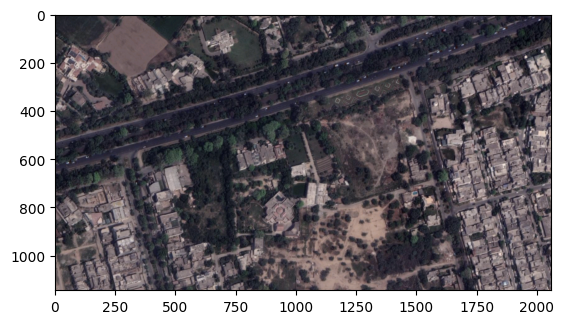

In [ ]:
plt.imshow(Image.open('img_1.png'))

In [ ]:
image = Image.open('img_1.jpeg')
image = image.resize((256,256))
image = np.array(image)
image = np.expand_dims(image, 0)

In [ ]:
model.get_config()

{'name': 'model',
 'trainable': True,
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   

In [ ]:
model.save('satellite-imagery.h5')

In [ ]:
saved_model = load_model('satellite-imagery.h5',custom_objects=({'dice_loss_plus_1focal_loss': total_loss,'jaccard_coef': jaccard_coef}))

In [ ]:
prediction = saved_model.predict(image)


1/1 [==============================] - 0s 453ms/step


In [ ]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

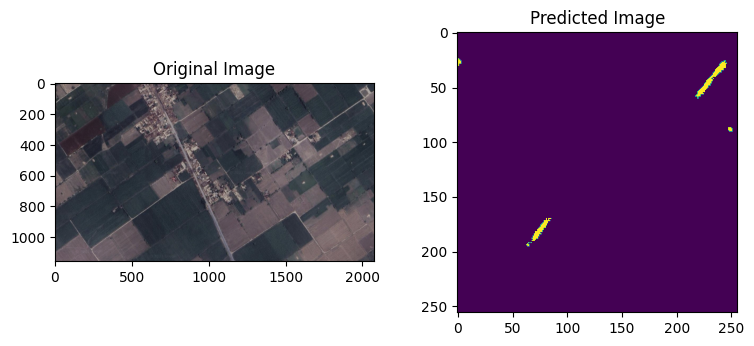

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('img_1.jpeg'))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)


### **Activation Output**

In [ ]:
!pip install keract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import keract as ke

In [ ]:
from keras.models import load_model

saved_model = load_model('satellite_segmentation_full.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss,
                                          'jaccard_coef': jaccard_coef}))


In [ ]:
activations = ke.get_activations(saved_model, image, nodes_to_evaluate=None, output_format='simple', auto_compile=True)

In [ ]:
ke.display_activations(activations, cmap='viridis', save=True, directory='/content/activations')

input_1 (1, 256, 256, 3) 
conv2d (1, 256, 256, 16) 
dropout (1, 256, 256, 16) 
conv2d_1 (1, 256, 256, 16) 
max_pooling2d (1, 128, 128, 16) 
conv2d_2 (1, 128, 128, 32) 
dropout_1 (1, 128, 128, 32) 
conv2d_3 (1, 128, 128, 32) 
max_pooling2d_1 (1, 64, 64, 32) 
conv2d_4 (1, 64, 64, 64) 
dropout_2 (1, 64, 64, 64) 
conv2d_5 (1, 64, 64, 64) 
max_pooling2d_2 (1, 32, 32, 64) 
conv2d_6 (1, 32, 32, 128) 
dropout_3 (1, 32, 32, 128) 
conv2d_7 (1, 32, 32, 128) 
max_pooling2d_3 (1, 16, 16, 128) 
conv2d_8 (1, 16, 16, 256) 
dropout_4 (1, 16, 16, 256) 
conv2d_9 (1, 16, 16, 256) 
conv2d_transpose (1, 32, 32, 128) 
concatenate (1, 32, 32, 256) 
conv2d_10 (1, 32, 32, 128) 
dropout_5 (1, 32, 32, 128) 
conv2d_11 (1, 32, 32, 128) 
conv2d_transpose_1 (1, 64, 64, 64) 
concatenate_1 (1, 64, 64, 128) 
conv2d_12 (1, 64, 64, 64) 
dropout_6 (1, 64, 64, 64) 
conv2d_13 (1, 64, 64, 64) 
conv2d_transpose_2 (1, 128, 128, 32) 
concatenate_2 (1, 128, 128, 64) 
conv2d_14 (1, 128, 128, 32) 
dropout_7 (1, 128, 128, 32) 
conv2

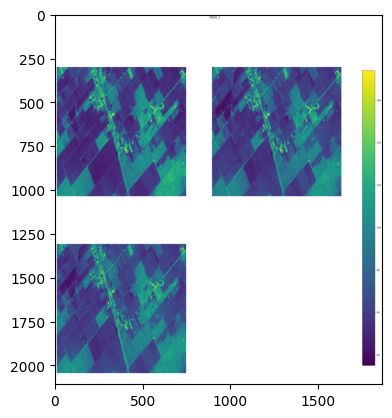

In [ ]:
plt.imshow(Image.open('/content/activations/0_input_1.png'))

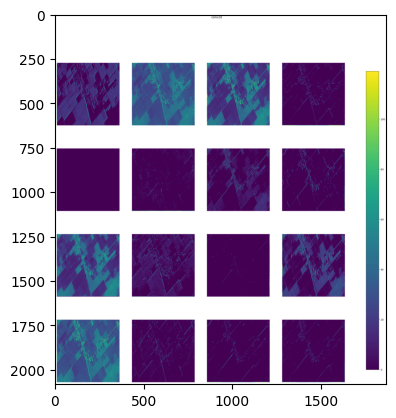

In [ ]:
plt.imshow(Image.open('/content/activations/1_conv2d.png'))


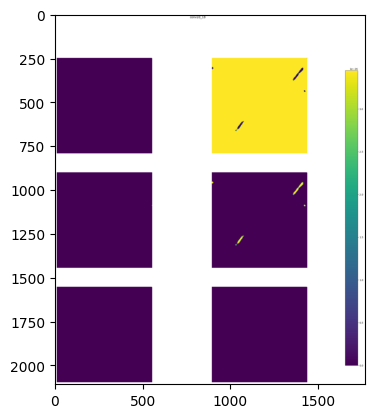

In [ ]:
plt.imshow(Image.open('/content/activations/40_conv2d_18.png'))